In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

punct = string.punctuation
stop_words =stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [5]:
# function to clean
def remove_punctuation(w_list):
    return [word for word in w_list if word not in punct]

def remove_stopwords(w_list):
    return [word for word in w_list if word not in stop_words]

def remove_number(w_list):
    return [word for word in w_list if not word.isnumeric()]

def get_tag(tag):
    if tag.startswith('j'):
        return 'a'
    elif tag.startswith('v'):
        return 'v'
    elif tag.startswith('n'):
        return 'n'
    elif tag.startswith('r'):
        return 'r'
    else:
        return None

def lemmatize(w_list):
    lemmatized=[]
    tagging=pos_tag(w_list)
    for word,tag in tagging:
        tag=get_tag(tag.lower())
        if tag is None:
            lemmatized.append(word)
        else:
            lemmatized.append(lemmatizer.lemmatize(word,tag))
    return lemmatized


In [6]:
import json
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load intents data
with open("./Dataset/intents.json", encoding="utf-8") as file:
    intents = json.load(file)

# Collect unique words from patterns
words = []
sentences = []
for intent in intents["intents"]:
    for pattern in intent["patterns"]:
        sentence = word_tokenize(pattern.lower())
        sentence = remove_stopwords(sentence)
        sentence = remove_punctuation(sentence)
        sentence = remove_number(sentence)
        
        words.extend(sentence)
        sentences.append(sentence)

words = remove_stopwords(words)
words = remove_punctuation(words)
words = remove_number(words)
# words = lemmatize(words)
print(len(words))

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=2, min_count=1, workers=4)

3281


In [7]:
import pickle

# Save words
with open("./Dataset/words_w2v.pkl", "wb") as file:
    pickle.dump(words, file)

In [8]:
def get_average_doc_vector(sentence, model):
    sentence_words = word_tokenize(sentence.lower())
    vector_sum = np.zeros(model.vector_size)
    num_valid_words = 0
    
    for word in sentence_words:
        if word in model.wv:
            vector_sum += model.wv[word]
            num_valid_words += 1
    
    if num_valid_words == 0:
        # If there are no valid words in the sentence
        return np.zeros(model.vector_size)
    else:
        # Calculate the average vector
        return vector_sum / num_valid_words


In [9]:
# Prepare training data
training_data = []

for intent in intents["intents"]:
    for pattern in intent["patterns"]:
        sentence_vector = get_average_doc_vector(pattern, word2vec_model)
        class_label = intent["tag"].strip()
        training_data.append({"input": sentence_vector, "output": class_label})
            
# Shuffle training data
np.random.shuffle(training_data)

# Prepare X_train and y_train
X_train = np.array([data["input"] for data in training_data])
y_train = np.array([data["output"] for data in training_data])
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

# Convert y_train to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print(y_train_encoded.shape,y_train_encoded)


X_train: (952, 100)
y_train: (952,)
(952,) [199 145 139  68   5 151 147 212 101 148 111   0  71 199 169 111  33  69
  55 106  54  55  81 171 203  68   4  82 213  51  10 131 114 116  52 227
 152 149  71  21 160 150  37  73 216 200  81 240 245  64 218  48 169 229
 200 126 159 248 190 108 140 166  44   0 222 200 182 193 170 125 169 178
 121 227 213 163   2  61 104 107 187 156 139  68 124  56 221 190  96 139
 120  42  41 178  98 237 212 179 204  99   2  56  74 148 197 128 170 176
  25  99 146 157 124 138  18 191 111  68 147 198  31 197  32 200  20 106
 191  63 112 140 242 242 255 169  49 120 115 190 228  17 109 129  56 191
 223  16  48 122 220 175 214 106 200 197  33 118 102  79  93  20  49 205
 251   1 100 234   9 200 158  27  96 183  89 238 201  58 244 115 241  25
  58 107 138 248 186 204  66  89 121 173  62  76 166  28 192  79 168 109
  60 241  72  64  68 186 171  83  75 153  21 124  14 172  39  28  83 169
  82  53  92  25 195 192 187 161 123  50 130 124  68 172 168 151 197 198
 255  17

In [10]:
with open("label_encoder_w2v.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

In [11]:
num_classes = len(label_encoder.classes_)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)

print(y_train_one_hot.shape)

count=0
for i in range(y_train_one_hot.shape[0]):
    for j in range(y_train_one_hot.shape[1]):
        if y_train_one_hot[i][j] == 1:
            print(j,y_train_one_hot[i], y_train_encoded[i])
            count+=1
    if count<=2:
            break
print(count)

(952, 256)
199 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 199
1


In [12]:
y_train_encoded[191]

76

In [13]:
label_encoder.inverse_transform([y_train_encoded[191]])

array(['Sampling'], dtype='<U66')

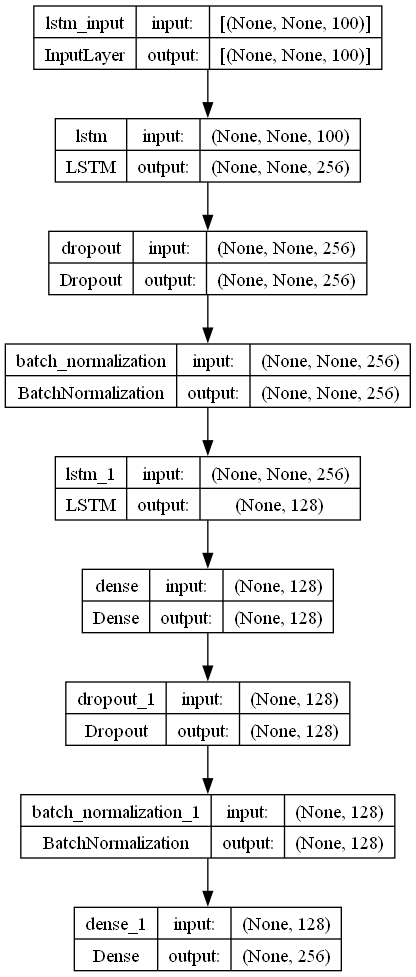

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

# Creating the model
model = Sequential([
    LSTM(256, input_shape=(None, X_train.shape[1]), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

# adam = Adam(learning_rate=0.005)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
plot_model(model,show_shapes=True,show_layer_names=True)

In [15]:
print(X_train.shape)
# Reshape X_train to match the input shape
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(X_train_reshaped, y_train_one_hot, epochs=150, batch_size=16, verbose=1, callbacks=early_stopping)

# Save the trained Word2Vec model and chatbot model
word2vec_model.save("./Model/word2vec_model.Models")
model.save("./Model/Model_Chatbot_Personal_W2V_LSTM.h5")

(952, 100)
Epoch 1/150
60/60 [==============================] - 115s 107ms/step - loss: 5.5183 - accuracy: 0.0273
Epoch 2/150
60/60 [==============================] - 6s 94ms/step - loss: 5.2831 - accuracy: 0.0735
Epoch 3/150
60/60 [==============================] - 0s 8ms/step - loss: 4.7501 - accuracy: 0.1313
Epoch 4/150
60/60 [==============================] - 9s 147ms/step - loss: 4.0905 - accuracy: 0.2017
Epoch 5/150
60/60 [==============================] - 5s 88ms/step - loss: 3.4639 - accuracy: 0.2931
Epoch 6/150
60/60 [==============================] - 0s 8ms/step - loss: 2.9222 - accuracy: 0.3929
Epoch 7/150
60/60 [==============================] - 5s 83ms/step - loss: 2.4235 - accuracy: 0.5021
Epoch 8/150
60/60 [==============================] - 0s 8ms/step - loss: 2.0692 - accuracy: 0.5651
Epoch 9/150
60/60 [==============================] - 6s 103ms/step - loss: 1.7205 - accuracy: 0.6513
Epoch 10/150
60/60 [==============================] - 5s 85ms/step - loss: 1.4528 - acc